# Music Genre Classification
In this project, I have implemented a music genre classification system using the GTZAN dataset. The GTZAN dataset consists of 1000 audio tracks each 30 seconds long. It contains 10 genres, each represented by 100 tracks. The tracks are all 22050Hz Mono 16-bit audio files in .wav format.
Author: Sulagna Saha (saha23s@mtholyoke.edu)

### Instructions to run the code


1. Download the GTZAN dataset from the following link: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
2. Extract the dataset and place it in the 'Data' folder in the same directory as the notebook.
3. Run the code cells in the notebook to extract features from raw audio files and train the models.
4. The code cells are divided into two parts: Feature Extraction from Scratch and Feature Extraction Using Pre-trained VGGish Model.
5. The Feature Extraction from Scratch part extracts features from raw audio files and trains the models using LSTM, CNN, and Transformer architectures.
6. The Feature Extraction Using Pre-trained VGGish Model part extracts features using the pre-trained VGGish model and trains the models using LSTM, CNN, and Transformer architectures.
7. The results of the models are displayed at the end of each part.


### Installing and Importing Required Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
!pip install -q visualkeras
!pip install librosa

In [ ]:
!pip install tensorflow_hub
!pip install tensorflow

In [ ]:
# Data preprocessing
import pandas as pd
import numpy as np
import os, librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Visualization
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
from visualkeras import layered_view

# Model
import tensorflow_hub as hub
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import layers, Sequential
from keras.callbacks import EarlyStopping
import librosa.display

# Suppressing warnings
from warnings import filterwarnings
filterwarnings('ignore')

### Data Preprocessing and Visualization

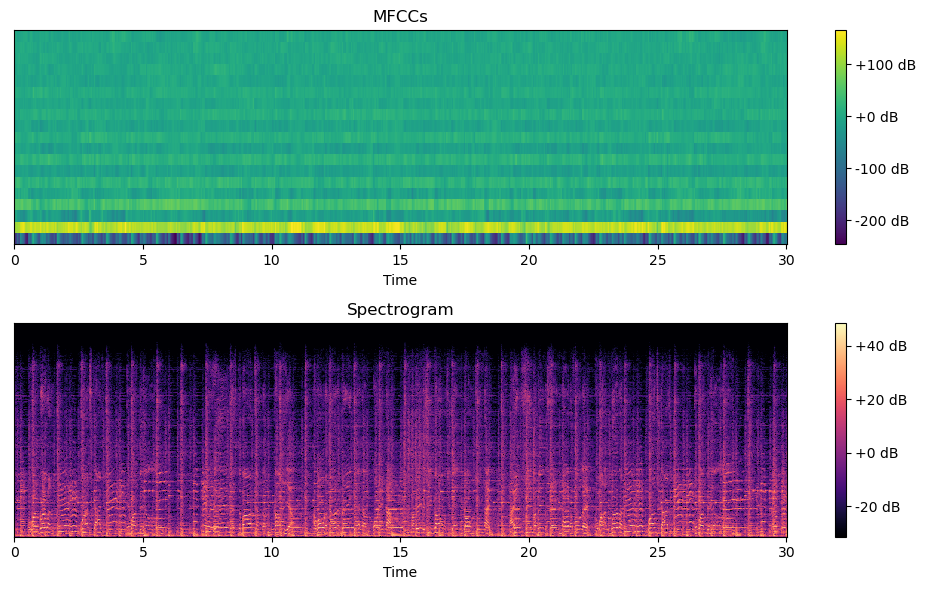

In [ ]:
# The dataset consists of 1000 audio tracks each 30 seconds long. It contains 10 genres, each represented by 100 tracks.
# The tracks are all 22050Hz Mono 16-bit audio files in .wav format.
# Since the dataset mentions that the audio files are sampled at 22050Hz, it means that each second of audio contains 22,050 amplitude samples.
# The audio files are mono, which means there is only one channel of audio data.
# The files are 16-bit, which means that each amplitude sample is quantized to an integer value between -32,768 and 32,767.

# Set the path to your Gtzan dataset directory
gtzan_dir = "./Data/genres_original"

# In the context of audio processing, y typically represents the raw audio signal itself, which is a one-dimensional array (or vector) of amplitude values over time.
# Each value in the y array corresponds to the amplitude of the audio signal at a specific point in time. The amplitude represents the air pressure fluctuations that our ears interpret as sound.
# y variable will be a one-dimensional NumPy array with 22050 * 30 = 661,500 elements.
# Load an audio file
file_path = os.path.join(gtzan_dir, "blues/blues.00000.wav")
y, sr = librosa.load(file_path, sr=None)

# This rescales the entire signal such that the maximum value (positive or negative) is now 1, while maintaining the relative proportions of the other values.
# Normalize the audio signal
y_normalized = y / np.max(np.abs(y))

# Compute MFCCs
# The librosa.feature.mfcc function takes three main arguments:
# y: The audio time series (the y_normalized array in your case, which is the normalized audio signal).
# sr: The sampling rate of the audio signal (in Hz).
# n_mfcc: The number of MFCC coefficients to return.

# This value of 19 is a common choice for many audio processing tasks, as it has been found to capture most of the relevant information in the spectral envelope.(ref?)
# Increasing the value of n_mfcc will result in more MFCC coefficients being computed. This means that the MFCC representation will capture more detailed information about the spectral envelope of the audio signal.
# Decreasing the value of n_mfcc will result in fewer MFCC coefficients being computed. This means that the MFCC representation will capture a more coarse or smoothed representation of the spectral envelope.
n_mfcc = 19
mfccs = librosa.feature.mfcc(y=y_normalized, sr=sr, n_mfcc=n_mfcc)


#computes the spectrogram of the audio signal y_normalized by:

# Calculating the Short-Time Fourier Transform (STFT) of the signal, which provides the Fourier coefficients for each time frame.
# Taking the absolute value of the complex-valued STFT output to obtain the magnitudes (amplitudes) of the Fourier coefficients.
# Squaring the magnitudes to represent the energy or power distribution across different frequencies over time, which is the spectrogram.

# The resulting spectrogram variable will be a 2D NumPy array, where the rows represent different frequencies,
# the columns represent different time frames, and the values in the array represent the energy or power of the signal at each time-frequency bin.'''

# Compute spectrogram
spectrogram = np.abs(librosa.stft(y_normalized))**2

# Visualize MFCCs and spectrogram
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(mfccs, x_axis="time", sr=sr, cmap="viridis")
plt.colorbar(format="%+2.0f dB")
plt.title("MFCCs")
plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.power_to_db(spectrogram), x_axis="time", sr=sr, cmap="magma")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.tight_layout()
plt.show()

### Data Filtering and Feature Extraction from Scratch

#### MFCCs and Spectrograms

In [ ]:
import os
import librosa
import numpy as np
from soundfile import LibsndfileError
from sklearn.preprocessing import LabelEncoder

# Set the path to your GTZAN dataset directory
gtzan_dir = "./Data/genres_original"

# Define the desired number of MFCCs and the spectrogram parameters
n_mfcc = 19
n_fft = 2048
hop_length = 512
max_frames = 1000  # Maximum number of frames for MFCCs

# Initialize lists to store MFCCs and spectrograms
mfccs = []
spectrograms = []
labels = []

# Loop over all genres and audio files
for genre in os.listdir(gtzan_dir):
    genre_path = os.path.join(gtzan_dir, genre)
    if os.path.isdir(genre_path):
        for audio_file in os.listdir(genre_path):
            if audio_file.endswith(".wav"):
                file_path = os.path.join(genre_path, audio_file)

                # Exclude the problematic file 'jazz.00054.wav'
                if os.path.basename(file_path) == 'jazz.00054.wav':
                    print(f"Skipping problematic file: {file_path}")
                    continue

                try:
                    # Load the audio file
                    y, sr = librosa.load(file_path, sr=None)
                    y = y / np.max(np.abs(y))

                    # Compute MFCCs
                    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
                    mfcc = librosa.util.fix_length(mfcc, size=max_frames)
                    mfccs.append(mfcc)

                    # Compute spectrogram
                    spectrogram = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))**2
                    spectrogram = librosa.util.fix_length(spectrogram, size=max_frames)
                    spectrograms.append(spectrogram)

                    # Store the genre label
                    labels.append(genre)

                except LibsndfileError as e:
                    print(f"Error loading file {file_path}: {e}")
                    continue

# Convert to NumPy arrays
mfccs = np.array(mfccs)
spectrograms = np.array(spectrograms)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)


Skipping problematic file: ./Data/genres_original/jazz/jazz.00054.wav


In [ ]:
print(mfccs.shape)
print(spectrograms.shape)
print(encoded_labels.shape)

(999, 19, 1000)
(999, 1025, 1000)
(999,)


In [ ]:
history_list = {}
evaluation_metrics_list = {}

#### Splitting the Dataset

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(spectrograms, encoded_labels, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (799, 1025, 1000)
Validation set shape: (200, 1025, 1000)
Test set shape: (200, 1025, 1000)


#### LSTM Model

In [ ]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

# Define LSTM model architecture
def create_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inputs)
    x = LSTM(128)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Compile the model
lstm_model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=len(np.unique(encoded_labels)))
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
# Train the model
history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.1627 - loss: 2.2473 - val_accuracy: 0.2200 - val_loss: 2.1363
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3244 - loss: 1.8832 - val_accuracy: 0.1700 - val_loss: 2.2363
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5234 - loss: 1.4484 - val_accuracy: 0.1600 - val_loss: 2.3949
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4744 - loss: 1.4766 - val_accuracy: 0.2500 - val_loss: 2.3331
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4758 - loss: 1.3203 - val_accuracy: 0.1950 - val_loss: 2.5286
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5361 - loss: 1.2424 - val_accuracy: 0.1800 - val_loss: 2.5677
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5590 - loss: 1.1720 - val_accuracy: 0.2250 - val_loss: 2.6156
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5494 - loss: 1.2220 - val_accuracy: 0.2150 - val_loss:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 471ms/step
Balanced Accuracy: 23.87%
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.95      0.32        22
           1       0.80      0.43      0.56        28
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        24
           4       0.40      0.10      0.16        20
           5       0.17      0.05      0.08        19
           6       0.00      0.00      0.00        12
           7       0.48      0.67      0.56        21
           8       0.09      0.07      0.08        15
           9       0.25      0.12      0.16        17

    accuracy                           0.27       200
   macro avg       0.24      0.24      0.19       200
weighted avg       0.27      0.27      0.22       200



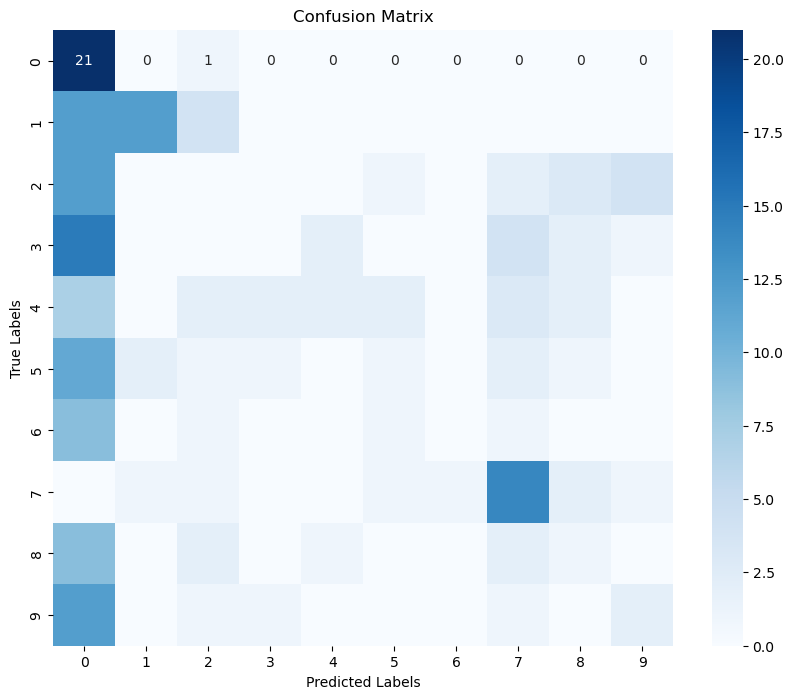

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions on the validation set
y_pred_probabilities = lstm_model.predict(X_val)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probabilities, axis=1)


# Balanced Accuracy Score
balanced_acc = balanced_accuracy_score(y_val, y_pred)
print("Balanced Accuracy: {:.2f}%".format(balanced_acc * 100))

# Classification Report
print("Classification Report:")
classification_rep = classification_report(y_val, y_pred)
print(classification_report(y_val, y_pred))

# Confusion Matrix
classes = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Store evaluation metrics in a dictionary
evaluation_metrics = {
    'Balanced Accuracy': balanced_acc,
    'Classification Report': classification_rep,
    'Confusion Matrix': cm
}

# Print and/or store the evaluation metrics dictionary as needed
print("Evaluation Metrics:")
for metric, value in evaluation_metrics.items():
    print(metric + ":")
    print(value)
    print()

Evaluation Metrics:
Balanced Accuracy:
0.23867288542211146

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.95      0.32        22
           1       0.80      0.43      0.56        28
           2       0.00      0.00      0.00        22
           3       0.00      0.00      0.00        24
           4       0.40      0.10      0.16        20
           5       0.17      0.05      0.08        19
           6       0.00      0.00      0.00        12
           7       0.48      0.67      0.56        21
           8       0.09      0.07      0.08        15
           9       0.25      0.12      0.16        17

    accuracy                           0.27       200
   macro avg       0.24      0.24      0.19       200
weighted avg       0.27      0.27      0.22       200


Confusion Matrix:
[[21  0  1  0  0  0  0  0  0  0]
 [12 12  4  0  0  0  0  0  0  0]
 [12  0  0  0  0  1  0  2  3  4]
 [15  0  0  0  2  0  0  4  2  1]
 [ 7  0

In [ ]:
# Retrieve training history
history_dict = history.history

# Store the training history in the history_list dictionary
history_list['lstm_model_scratch'] = history_dict
evaluation_metrics_list['lstm_model_scratch'] = evaluation_metrics

#### CNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define CNN model architecture
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Reshape X_train, X_val, and X_test to fit CNN model input shape
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Compile the CNN model
cnn_model = create_cnn_model(input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2], 1), num_classes=len(np.unique(y_train)))
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the CNN model with early stopping
history = cnn_model.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])
# cnn_model.save("cnn_scratch.h5")


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 233s 9s/step - accuracy: 0.1568 - loss: 11390.5469 - val_accuracy: 0.2000 - val_loss: 108.2847
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 236s 9s/step - accuracy: 0.4817 - loss: 20.3290 - val_accuracy: 0.1850 - val_loss: 5.7171
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3080s 128s/step - accuracy: 0.8270 - loss: 0.6985 - val_accuracy: 0.2100 - val_loss: 5.3706
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 270s 11s/step - accuracy: 0.9709 - loss: 0.2114 - val_accuracy: 0.1850 - val_loss: 6.5391
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 284s 11s/step - accuracy: 0.9789 - loss: 0.1159 - val_accuracy: 0.1900 - val_loss: 7.2080
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 290s 11s/step - accuracy: 0.9918 - loss: 0.0617 - val_accuracy: 0.1950 - val_loss: 7.3695
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 295s 12s/step - accuracy: 0.9893 - loss: 0.0698 - val_accuracy: 0.1950 - val_loss: 8.5796
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 309s 12s/step - accuracy: 0.9945 - loss: 0.0579 - val_accur

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
Evaluation Metrics:
Balanced Accuracy:
0.2142298929141034

Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.09      0.09        22
           1       0.43      0.11      0.17        28
           2       0.23      0.32      0.27        22
           3       0.46      0.25      0.32        24
           4       0.07      0.05      0.06        20
           5       0.21      0.47      0.29        19
           6       0.67      0.17      0.27        12
           7       0.29      0.29      0.29        21
           8       0.18      0.40      0.24        15
           9       0.00      0.00      0.00        17

    accuracy                           0.21       200
   macro avg       0.26      0.21      0.20       200
weighted avg       0.26      0.21      0.20       200


Confusion Matrix:
[[ 2  2  4  2  3  4  0  3  0  2]
 [ 2  3  2  2  0 14  0  0  1  4]
 [ 3  1  7  0  0  4  0  1  5  1]
 [ 2

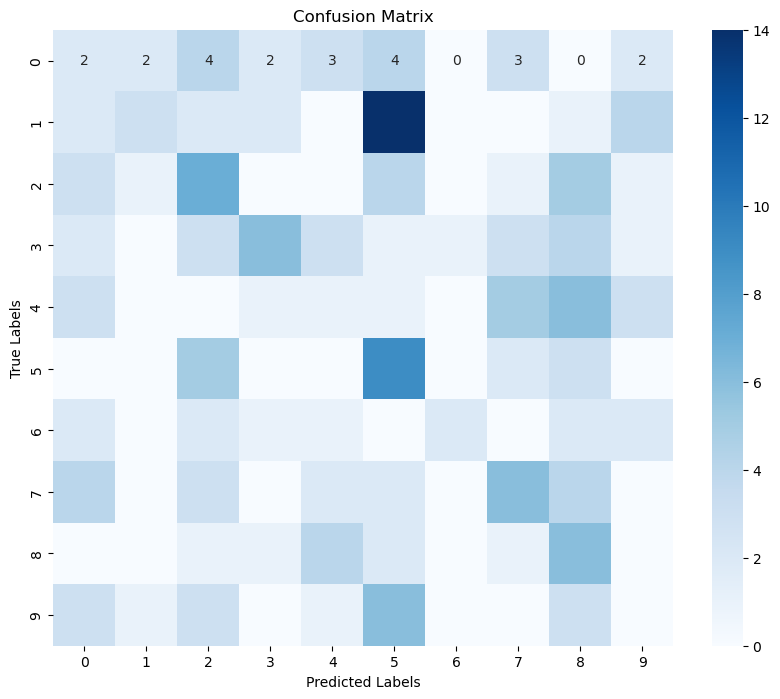

In [ ]:
# Make predictions on the validation set
y_pred_probabilities = cnn_model.predict(X_val_cnn)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Compute evaluation metrics
balanced_acc = balanced_accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Store evaluation metrics in a dictionary
evaluation_metrics = {
    'Balanced Accuracy': balanced_acc,
    'Classification Report': classification_rep,
    'Confusion Matrix': conf_matrix
}

# Print and/or store the evaluation metrics dictionary as needed
print("Evaluation Metrics:")
for metric, value in evaluation_metrics.items():
    print(metric + ":")
    print(value)
    print()

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Retrieve training history
history_dict = history.history

# Store the training history in the history_list dictionary
history_list['cnn_model_scratch'] = history_dict
evaluation_metrics_list['cnn_model_scratch'] = evaluation_metrics

#### Transformer Model

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.2586 - loss: 2.1159 - val_accuracy: 0.4250 - val_loss: 1.6687
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 796ms/step - accuracy: 0.4909 - loss: 1.5061 - val_accuracy: 0.5000 - val_loss: 1.4381
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 811ms/step - accuracy: 0.5451 - loss: 1.2721 - val_accuracy: 0.5900 - val_loss: 1.3252
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 837ms/step - accuracy: 0.6183 - loss: 1.0615 - val_accuracy: 0.6400 - val_loss: 1.1923
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 783ms/step - accuracy: 0.6544 - loss: 0.9943 - val_accuracy: 0.5800 - val_loss: 1.2202
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 770ms/step - accuracy: 0.7023 - loss: 0.9139 - val_accuracy: 0.6300 - val_loss: 1.1095
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 814ms/step - accuracy: 0.7589 - loss: 0.7408 - val_accuracy: 0.6350 - val_loss: 1.0596
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 851ms/step - accuracy: 0.8059 - loss: 0.6202 - val_accurac

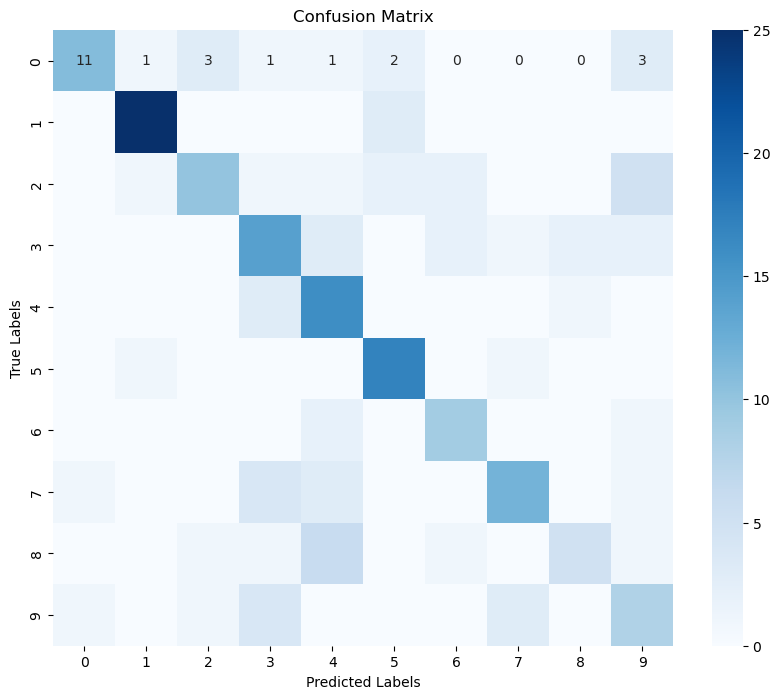

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the Transformer model architecture
def create_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder block
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = LayerNormalization()(x)
    x = Dropout(0.1)(x)

    # Multi-head self-attention
    x_att = MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
    x_att = Dropout(0.1)(x_att)

    # Skip connection and layer normalization
    x = LayerNormalization()(x + x_att)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Dense layers for classification
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Reshape X_train, X_val, and X_test for Transformer model input shape
X_train_transformer = X_train.transpose(0, 2, 1)  # Transpose to shape (num_samples, num_time_frames, num_frequency_bins)
X_val_transformer = X_val.transpose(0, 2, 1)
X_test_transformer = X_test.transpose(0, 2, 1)

# Define the input shape and number of classes
input_shape = (X_train_transformer.shape[1], X_train_transformer.shape[2])
num_classes = len(np.unique(y_train))

# Create and compile the Transformer model
transformer_model = create_transformer_model(input_shape, num_classes)
transformer_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the Transformer model with early stopping
history = transformer_model.fit(X_train_transformer, y_train, validation_data=(X_val_transformer, y_val), epochs=20, batch_size=32, callbacks=[early_stopping])

# Make predictions on the validation set
y_pred = np.argmax(transformer_model.predict(X_val_transformer), axis=1)

# Compute evaluation metrics
balanced_acc = balanced_accuracy_score(y_val, y_pred)
classification_rep = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Store evaluation metrics in a dictionary
evaluation_metrics = {
    'Balanced Accuracy': balanced_acc,
    'Classification Report': classification_rep,
    'Confusion Matrix': conf_matrix
}

# Print and/or store the evaluation metrics dictionary as needed
print("Evaluation Metrics:")
for metric, value in evaluation_metrics.items():
    print(metric + ":")
    print(value)
    print()

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Retrieve training history
history_dict = history.history

# Store the training history in the history_list dictionary
history_list['transformer_model_scratch'] = history_dict
evaluation_metrics_list['transformer_model_scratch'] = evaluation_metrics

### Feature Extraction Using Pre-trained VGGish Model

#### Loading VGGish Model

In [ ]:
# Loading VGGish model from TensorFlow Hub
vggish = hub.load('https://tfhub.dev/google/vggish/1')

In [ ]:
# Reference for where I knew VGGish model from: https://www.kaggle.com/code/bhaveshmittal/music-genre-classification-vggish-cnn

In [ ]:
# Function to extract audio features using VGGish
def extractFeatures(audioFile):
    try:
        # Loading audio file
        waveform, sr = librosa.load(audioFile)

        # Trimming silence
        waveform, _ = librosa.effects.trim(waveform)

        # Extracting features using VGGish
        return vggish(waveform).numpy()
    except:
        return None

In [ ]:
# Root directory containing the audio files
root = './Data/genres_original'
data = []

# Iterating through the folders and files to extract features
for folder in os.listdir(root):
    folderPath = os.path.join(root, folder)

    for file in tqdm(os.listdir(folderPath), desc = f'Processing folder {folder}'):
        filePath = os.path.join(folderPath, file)
        features = extractFeatures(filePath)

        if features is not None:
            data.append([features, folder])

Processing folder jazz: 100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


In [ ]:
# Converting list into dataframe
data = pd.DataFrame(data, columns = ['Features', 'Class'])
data.head()

,Features,Class
0,"[[-0.376731, -0.068882436, 0.066517875, -0.032...",pop
1,"[[-0.55521417, 0.12716083, 0.23620814, -0.3313...",pop
2,"[[-0.7635881, 0.063004345, 0.2167502, -0.33189...",pop
3,"[[-0.7401831, -0.050077677, 0.22357027, 0.0888...",pop
4,"[[-0.4112626, 0.038893625, 0.37897837, -0.2935...",pop


#### Data Preprocessing

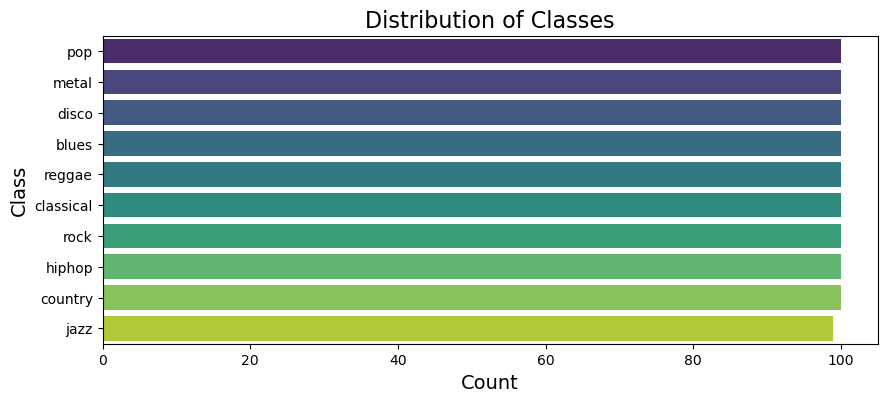

In [ ]:
# Plotting count distribution of classes
plt.figure(figsize = (10, 4))
sns.countplot(y = data['Class'], palette = 'viridis')
plt.title('Distribution of Classes', fontsize = 16)
plt.xlabel('Count', fontsize = 14)
plt.ylabel('Class', fontsize = 14)
plt.show()

In [ ]:
# Padding or truncating the arrays to a fixed length
x = data['Features'].tolist()
x = pad_sequences(x, dtype = 'float32', padding = 'post', truncating = 'post')
x.shape

(999, 43, 128)

In [ ]:
# Encoding class labels
encoder = LabelEncoder()
y = encoder.fit_transform(data['Class'])
y = to_categorical(y)

#### Splitting the Dataset

In [ ]:
trainX, val_testX, trainY, val_testY = train_test_split(x, y, test_size=0.3, random_state=0)
valX, testX, valY, testY = train_test_split(val_testX, val_testY, test_size=0.5, random_state=0)

In [ ]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(699, 43, 128)
(150, 43, 128)
(699, 10)
(150, 10)


#### LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
import numpy as np

# Define LSTM model architecture
def create_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inputs)
    x = LSTM(128)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Reshape trainX and testX if necessary
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2])  # No need to reshape, assuming trainX is already in the correct shape
testX = testX.reshape(testX.shape[0], testX.shape[1], testX.shape[2])  # No need to reshape, assuming testX is already in the correct shape

# Compile the model
lstm_model = create_lstm_model(input_shape=(trainX.shape[1], trainX.shape[2]), num_classes=trainY.shape[1])
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.save('lstm_vggish.h5')

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.3585 - loss: 1.8937 - val_accuracy: 0.6933 - val_loss: 1.0188
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7037 - loss: 0.8870 - val_accuracy: 0.7133 - val_loss: 0.8678
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7418 - loss: 0.7276 - val_accuracy: 0.7000 - val_loss: 0.8059
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8066 - loss: 0.6089 - val_accuracy: 0.7133 - val_loss: 0.7941
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8399 - loss: 0.5156 - val_accuracy: 0.7667 - val_loss: 0.7691
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8404 - loss: 0.4507 - val_accuracy: 0.7867 - val_loss: 0.6667
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8334 - loss: 0.4502 - val_accuracy: 0.7467 - val_loss: 0.8566
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8615 - loss: 0.4207 - val_accuracy: 0.7867 - v

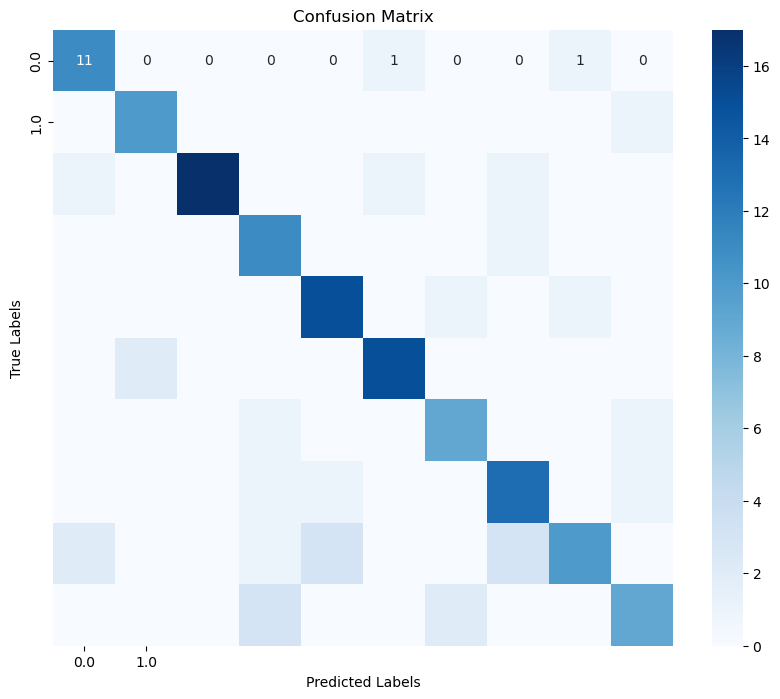

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = lstm_model.fit(trainX, trainY, epochs=20, batch_size=32, callbacks=[early_stopping], validation_data=(valX, valY))

# Make predictions on the test set
y_pred_probabilities = lstm_model.predict(testX)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Compute evaluation metrics
balanced_acc = balanced_accuracy_score(np.argmax(testY, axis=1), y_pred)
classification_rep = classification_report(np.argmax(testY, axis=1), y_pred)
conf_matrix = confusion_matrix(np.argmax(testY, axis=1), y_pred)

# Print evaluation metrics
print("Balanced Accuracy:", balanced_acc)
print("Classification Report:")
print(classification_rep)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(testY), yticklabels=np.unique(testY))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Store evaluation metrics in a dictionary
evaluation_metrics = {
    'Balanced Accuracy': balanced_acc,
    'Classification Report': classification_rep,
    'Confusion Matrix': cm
}

In [ ]:
# Retrieve training history
history_dict = history.history

# Store the training history in the history_list dictionary
history_list['lstm_model_vggish'] = history_dict
evaluation_metrics_list['lstm_model_vggish'] = evaluation_metrics

#### CNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define CNN model architecture
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Reshape trainX, valX, and testX to fit CNN model input shape
trainX_cnn = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2], 1)  # Add channel dimension
valX_cnn = valX.reshape(valX.shape[0], valX.shape[1], valX.shape[2], 1)  # Add channel dimension
testX_cnn = testX.reshape(testX.shape[0], testX.shape[1], testX.shape[2], 1)  # Add channel dimension

# Compile the CNN model
cnn_model = create_cnn_model(input_shape=(trainX_cnn.shape[1], trainX_cnn.shape[2], 1), num_classes=trainY.shape[1])
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.save('cnn_vggish.h5')

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.2021 - loss: 2.4000 - val_accuracy: 0.4067 - val_loss: 1.5827
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5726 - loss: 1.2567 - val_accuracy: 0.5533 - val_loss: 1.1733
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6996 - loss: 0.9486 - val_accuracy: 0.6933 - val_loss: 0.8994
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7755 - loss: 0.6253 - val_accuracy: 0.7333 - val_loss: 0.7999
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.8310 - loss: 0.5061 - val_accuracy: 0.7667 - val_loss: 0.7576
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8501 - loss: 0.4623 - val_accuracy: 0.8533 - val_loss: 0.6038
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8945 - loss: 0.3185 - val_accuracy: 0.8133 - val_loss: 0.6118
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9073 - loss: 0.2616 - val_accuracy: 0.8400 - v

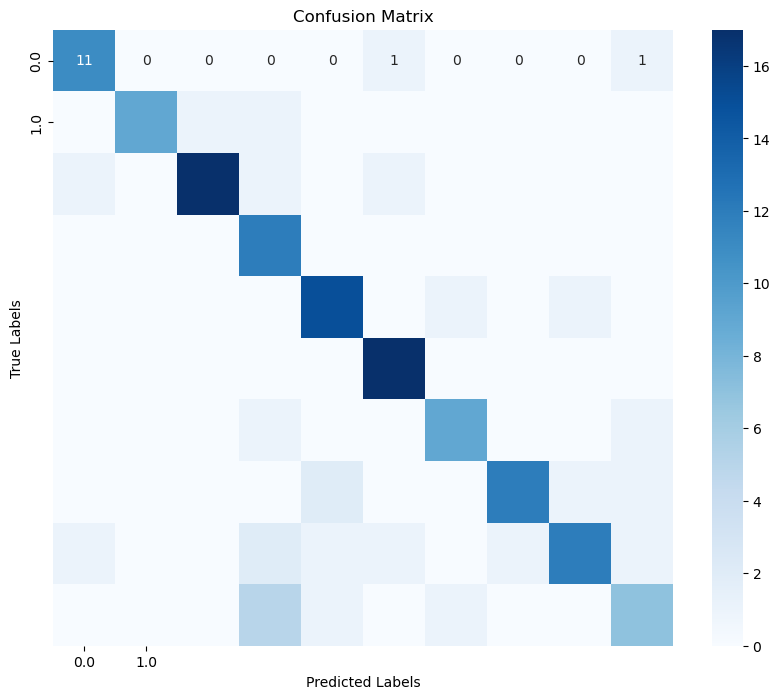

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the CNN model with early stopping and validation data
history = cnn_model.fit(trainX_cnn, trainY, epochs=20, batch_size=32, callbacks=[early_stopping], validation_data=(valX_cnn, valY))

# Evaluate the CNN model on the test set
loss, accuracy = cnn_model.evaluate(testX_cnn, testY)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
y_pred_probabilities = cnn_model.predict(testX_cnn)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Compute evaluation metrics
balanced_acc = balanced_accuracy_score(np.argmax(testY, axis=1), y_pred)
classification_rep = classification_report(np.argmax(testY, axis=1), y_pred)
conf_matrix = confusion_matrix(np.argmax(testY, axis=1), y_pred)

# Print evaluation metrics
print("Balanced Accuracy:", balanced_acc)
print("Classification Report:")
print(classification_rep)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(testY), yticklabels=np.unique(testY))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Store evaluation metrics in a dictionary
evaluation_metrics = {
    'Balanced Accuracy': balanced_acc,
    'Classification Report': classification_rep,
    'Confusion Matrix': cm
}

In [ ]:
# Retrieve training history
history_dict = history.history

# Store the training history in the history_list dictionary
history_list['cnn_model_vggish'] = history_dict
evaluation_metrics_list['cnn_model_vggish'] = evaluation_metrics

#### Transformer Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

# Define the Transformer model architecture
def create_transformer_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder block
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = LayerNormalization()(x)
    x = Dropout(0.1)(x)

    # Multi-head self-attention
    x_att = MultiHeadAttention(num_heads=2, key_dim=64)(x, x)
    x_att = Dropout(0.1)(x_att)

    # Skip connection and layer normalization
    x = LayerNormalization()(x + x_att)

    # Global average pooling
    x = GlobalAveragePooling1D()(x)

    # Dense layers for classification
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Define the input shape and number of classes
input_shape = trainX.shape[1:]
num_classes = trainY.shape[1]

# Create and compile the Transformer model
transformer_model = create_transformer_model(input_shape, num_classes)
transformer_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
transformer_model.save('trans_vggish.h5')

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3750 - loss: 1.7899 - val_accuracy: 0.6600 - val_loss: 1.0670
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7294 - loss: 0.9294 - val_accuracy: 0.7800 - val_loss: 0.8235
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7732 - loss: 0.7155 - val_accuracy: 0.7400 - val_loss: 0.7213
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8171 - loss: 0.6094 - val_accuracy: 0.8133 - val_loss: 0.6296
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8427 - loss: 0.4752 - val_accuracy: 0.8400 - val_loss: 0.5732
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8614 - loss: 0.4407 - val_accuracy: 0.8200 - val_loss: 0.5662
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8710 - loss: 0.3967 - val_accuracy: 0.8267 - val_loss: 0.4849
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9015 - loss: 0.3148 - val_accuracy: 0.8267 - v

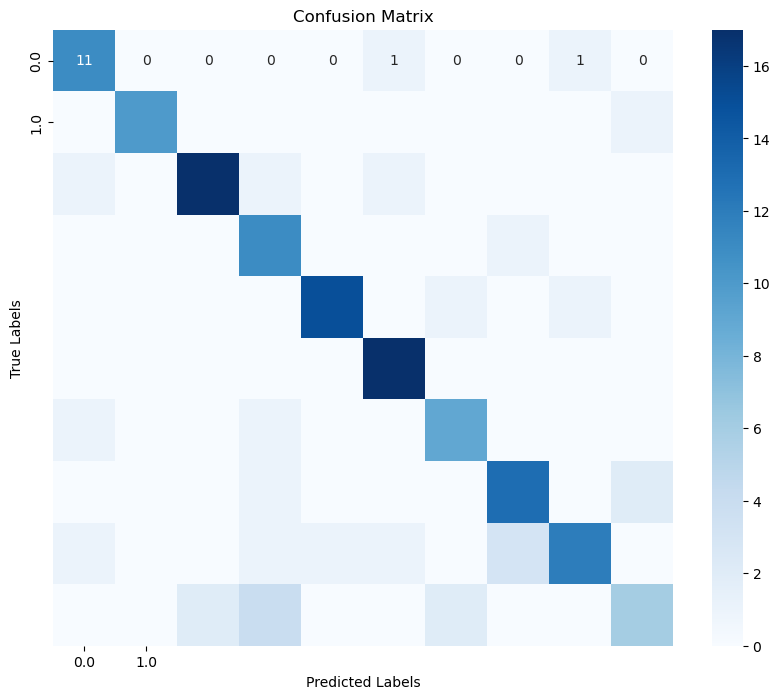

In [ ]:
# Train the Transformer model with early stopping and validation data
history = transformer_model.fit(trainX, trainY, epochs=20, batch_size=32, callbacks=[early_stopping], validation_data=(valX, valY))

# Evaluate the Transformer model on the test set
loss, accuracy = transformer_model.evaluate(testX, testY)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Make predictions on the test set
y_pred_probabilities = transformer_model.predict(testX)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Compute evaluation metrics
balanced_acc = balanced_accuracy_score(np.argmax(testY, axis=1), y_pred)
classification_rep = classification_report(np.argmax(testY, axis=1), y_pred)
conf_matrix = confusion_matrix(np.argmax(testY, axis=1), y_pred)

# Print evaluation metrics
print("Balanced Accuracy:", balanced_acc)
print("Classification Report:")
print(classification_rep)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=np.unique(testY), yticklabels=np.unique(testY))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Store evaluation metrics in a dictionary
evaluation_metrics = {
    'Balanced Accuracy': balanced_acc,
    'Classification Report': classification_rep,
    'Confusion Matrix': cm
}

In [ ]:
# Retrieve training history
history_dict = history.history

# Store the training history in the history_list dictionary
history_list['transformer_model_vggish'] = history_dict
evaluation_metrics_list['transformer_model_vggish'] = evaluation_metrics

### Evaluation Methods

In [ ]:
print(evaluation_metrics_list)

{'lstm_model_scratch': {'Balanced Accuracy': 0.19945719914760163, 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.19      0.95      0.31        22\n           1       0.71      0.18      0.29        28\n           2       0.00      0.00      0.00        22\n           3       0.18      0.08      0.11        24\n           4       0.00      0.00      0.00        20\n           5       0.25      0.05      0.09        19\n           6       0.00      0.00      0.00        12\n           7       0.44      0.67      0.53        21\n           8       0.00      0.00      0.00        15\n           9       0.20      0.06      0.09        17\n\n    accuracy                           0.22       200\n   macro avg       0.20      0.20      0.14       200\nweighted avg       0.23      0.22      0.16       200\n', 'Confusion Matrix': array([[21,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [16,  5,  4,  0,  0,  2,  1,  0,  0,  0],
       [13,  

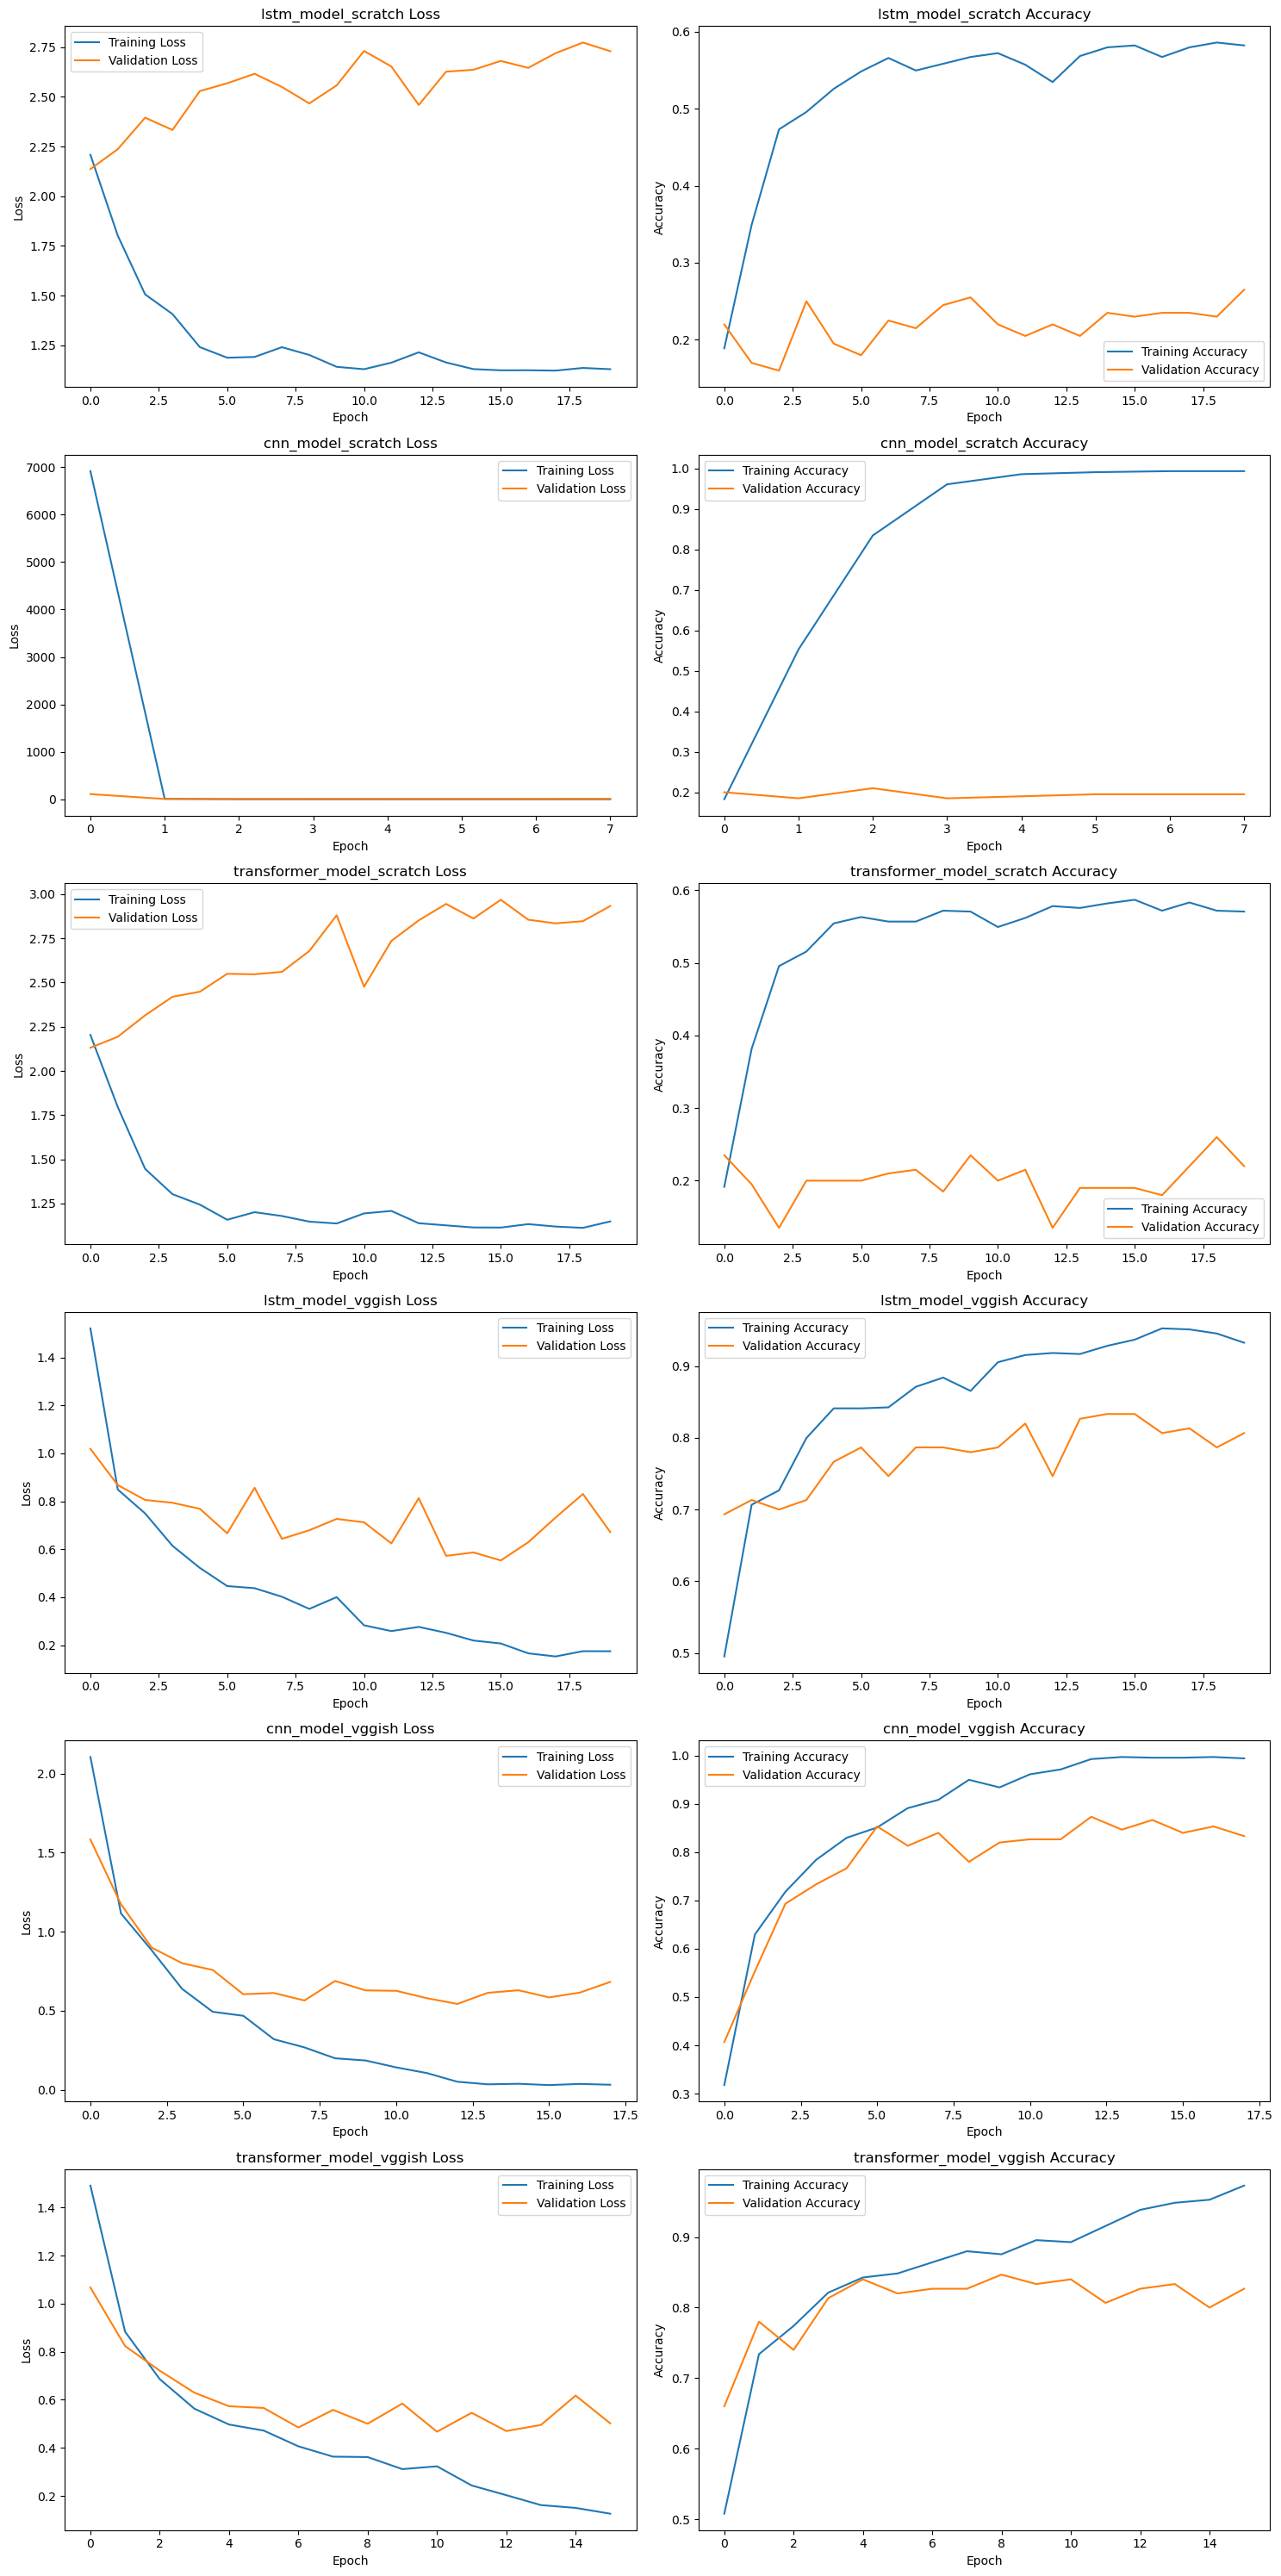

In [ ]:
import matplotlib.pyplot as plt
models = ['lstm_model_scratch', 'cnn_model_scratch', 'transformer_model_scratch', 'lstm_model_vggish', 'cnn_model_vggish', 'transformer_model_vggish']
# Define a function to plot model history
def plot_model_history(models, history_list):
    # Create subplots for each model
    num_models = len(models)
    fig, axes = plt.subplots(nrows=num_models, ncols=2, figsize=(15, 5*num_models))

    # Plot training and validation loss and accuracy for each model
    for i, model in enumerate(models):
        history = history_list[model]

        # Plot training and validation loss
        axes[i, 0].plot(history['loss'], label='Training Loss')
        axes[i, 0].plot(history['val_loss'], label='Validation Loss')
        axes[i, 0].set_title(f'{model} Loss')
        axes[i, 0].set_xlabel('Epoch')
        axes[i, 0].set_ylabel('Loss')
        axes[i, 0].legend()

        # Plot training and validation accuracy
        axes[i, 1].plot(history['accuracy'], label='Training Accuracy')
        axes[i, 1].plot(history['val_accuracy'], label='Validation Accuracy')
        axes[i, 1].set_title(f'{model} Accuracy')
        axes[i, 1].set_xlabel('Epoch')
        axes[i, 1].set_ylabel('Accuracy')
        axes[i, 1].legend()

    plt.tight_layout()
    plt.show()

# Call the function with your models and their history
plot_model_history(models, history_list)


In [ ]:
print(evaluation_metrics_list['lstm_model_scratch'])

{'Balanced Accuracy': 0.23867288542211146, 'Classification Report': '              precision    recall  f1-score   support\n\n           0       0.19      0.95      0.32        22\n           1       0.80      0.43      0.56        28\n           2       0.00      0.00      0.00        22\n           3       0.00      0.00      0.00        24\n           4       0.40      0.10      0.16        20\n           5       0.17      0.05      0.08        19\n           6       0.00      0.00      0.00        12\n           7       0.48      0.67      0.56        21\n           8       0.09      0.07      0.08        15\n           9       0.25      0.12      0.16        17\n\n    accuracy                           0.27       200\n   macro avg       0.24      0.24      0.19       200\nweighted avg       0.27      0.27      0.22       200\n', 'Confusion Matrix': array([[21,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [12, 12,  4,  0,  0,  0,  0,  0,  0,  0],
       [12,  0,  0,  0,  0,  1,  0, 

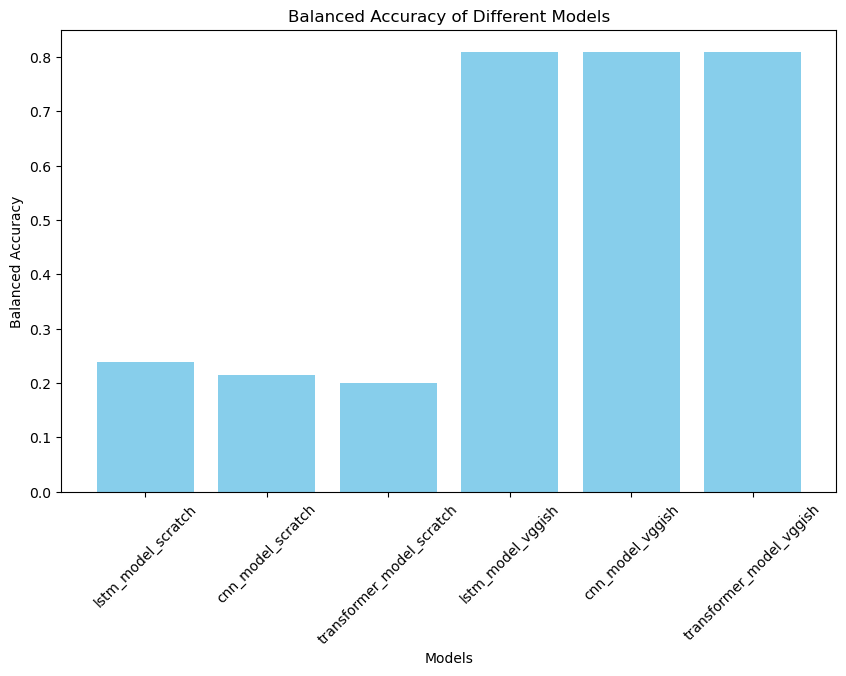

In [ ]:
import matplotlib.pyplot as plt

# Define the model names
model_names = ['lstm_model_scratch', 'cnn_model_scratch', 'transformer_model_scratch', 'lstm_model_vggish', 'cnn_model_vggish', 'transformer_model_vggish']

# Extract balanced accuracy for each model
balanced_acc_list = [evaluation_metrics_list[model]['Balanced Accuracy'] for model in model_names]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, balanced_acc_list, color='skyblue')
plt.xlabel('Models')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy of Different Models')
plt.xticks(rotation=45)
plt.show()



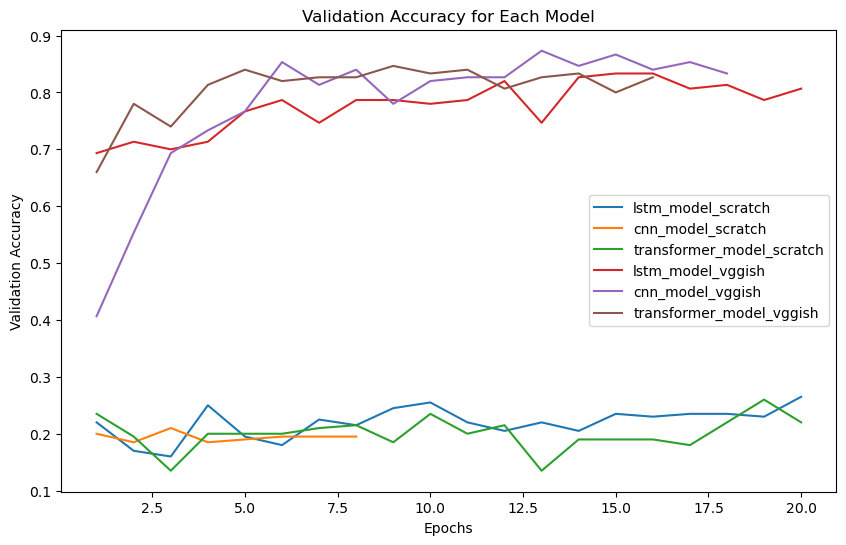

In [ ]:
# Plot validation accuracy for each model
plt.figure(figsize=(10, 6))
for model_name in model_names:
    history = history_list[model_name]
    val_accuracy = history['val_accuracy']
    epochs = range(1, len(val_accuracy) + 1)
    plt.plot(epochs, val_accuracy, label=model_name)

plt.title('Validation Accuracy for Each Model')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

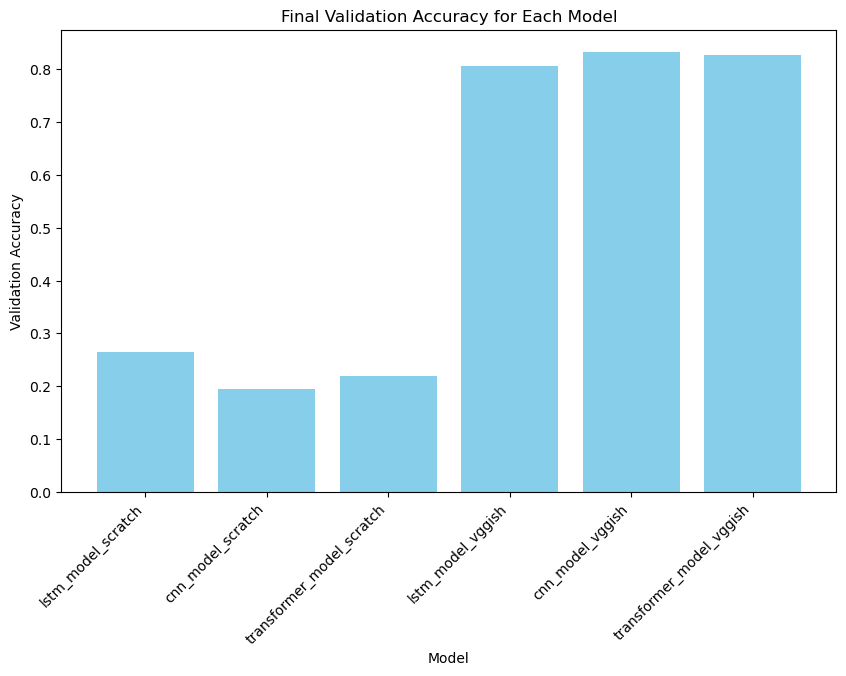

In [ ]:
import matplotlib.pyplot as plt

# Define model names
model_names = ['lstm_model_scratch', 'cnn_model_scratch', 'transformer_model_scratch',
               'lstm_model_vggish', 'cnn_model_vggish', 'transformer_model_vggish']

# Extract and plot final validation accuracy for each model
final_val_accuracy = []
for model_name in model_names:
    history = history_list[model_name]
    val_accuracy = history['val_accuracy']
    final_val_accuracy.append(val_accuracy[-1])

# Plot final validation accuracy for each model
plt.figure(figsize=(10, 6))
plt.bar(model_names, final_val_accuracy, color='skyblue')
plt.title('Final Validation Accuracy for Each Model')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.xticks(rotation=45, ha='right')
plt.show()